# Human Emotion Detection on FER2013 Dataset
### By:
#### - Veer Bains (50363319)
#### - Kunal Beniwal (50381672)

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
PATH = "C:\\Users\\veerb\\Downloads\\deep_learning\\project\\fer2013\\fer2013.csv"

device(type='cuda')

In [1]:
import numpy as np
import pandas as pd
import cv2
import netron
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision

### Importing Data

In [3]:
data = pd.read_csv(PATH)

In [4]:

lookup = ('anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral')
y = data['emotion']
sns.countplot(x=y)
plt.xticks(range(7), lookup);

In [5]:
train_data = data[data.Usage =='Training'].reset_index(drop=True) 
val_data = data[data.Usage =='PrivateTest'].reset_index(drop=True) 
test_data = data[data.Usage =='PublicTest'].reset_index(drop=True) 

print(train_data.shape,val_data.shape,test_data.shape)

(28709, 3) (3589, 3) (3589, 3)


### Creating Dataset Class and Dataloaders

In [6]:
class FER2013(torch.utils.data.Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.loc[index]
        image, label = np.array([x.split() for x in self.data.loc[index, ['pixels']]]), row['emotion']
        image = np.asarray(image).astype(np.uint8).reshape(48, 48, 1)

        if self.transforms:
            image = self.transforms(image)
        return image, label

In [7]:


trfm_train = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])
trfm_val_test = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])

train_data = FER2013(train_data, trfm_train)
val_data = FER2013(val_data, trfm_val_test)
test_data = FER2013(test_data, trfm_val_test)

train_data[0]

(tensor([[[-0.6784, -0.6627, -0.5922,  ..., -0.3569, -0.3725, -0.4510],
          [-0.6549, -0.5922, -0.5608,  ..., -0.5451, -0.5216, -0.4902],
          [-0.6314, -0.5608, -0.6157,  ..., -0.5765, -0.6627, -0.6078],
          ...,
          [-0.6627, -0.5608, -0.4353,  ..., -0.6706, -0.4902, -0.2863],
          [-0.6392, -0.4510, -0.1765,  ..., -0.3804, -0.3569, -0.3961],
          [-0.3569, -0.1451, -0.1686,  ..., -0.3412, -0.4353, -0.3961]]]),
 0)

In [8]:
batch_size = 128

loader_train = torch.utils.data.DataLoader(train_data, batch_size,
shuffle=True, pin_memory=True)
loader_val = torch.utils.data.DataLoader(val_data, batch_size, pin_memory=True)
loader_test = torch.utils.data.DataLoader(test_data, batch_size, pin_memory=True)

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(loader_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


### Defining Model

In [10]:
class Model_base(torch.nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                 
        loss = torch.nn.functional.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                    
        loss = torch.nn.functional.cross_entropy(out, labels)   
        acc = accuracy(out, labels)         
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [11]:
def conv_block(in_chnl, out_chnl, padding=1):
    layers = [
        torch.nn.Conv2d(in_chnl, out_chnl, kernel_size=3, padding=padding, stride=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(out_chnl),
        torch.nn.MaxPool2d(2),
        torch.nn.Dropout(0.4)]
    return torch.nn.Sequential(*layers)

class Model(Model_base):
    def __init__(self, in_chnls, num_cls):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_chnls, 256, kernel_size=3, padding=1)
        self.block1 = conv_block(256, 512)
        self.block2 = conv_block(512, 384)
        self.block3 = conv_block(384, 192)
        self.block4 = conv_block(192, 384)

        self.classifier = torch.nn.Sequential(torch.nn.Flatten(),
                                        torch.nn.Linear(3456, 256),
                                        torch.nn.ReLU(),
                                        torch.nn.BatchNorm1d(256),
                                        torch.nn.Dropout(0.3),
                                        torch.nn.Linear(256, num_cls))    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.block1(out)
        out = self.block2(out)       
        out = self.block3(out)
        out = self.block4(out)

        return self.classifier(out)

### Defining Train and Eval Loops

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, loader_train, loader_val, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in loader_train:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, loader_val)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Model training

In [13]:
model = Model(1,7).to(device) 
optimizer = torch.optim.Adam
lr=0.001
num_epochs=20

history = fit(num_epochs, lr, model, loader_train, loader_val, optimizer)

Epoch [0], train_loss: 1.7588, val_loss: 1.5319, val_acc: 0.4157
Epoch [1], train_loss: 1.4378, val_loss: 1.3396, val_acc: 0.5009
Epoch [2], train_loss: 1.2998, val_loss: 1.1929, val_acc: 0.5488
Epoch [3], train_loss: 1.2041, val_loss: 1.1315, val_acc: 0.5701
Epoch [4], train_loss: 1.1422, val_loss: 1.1325, val_acc: 0.5627
Epoch [5], train_loss: 1.1044, val_loss: 1.0463, val_acc: 0.5994
Epoch [6], train_loss: 1.0913, val_loss: 1.0440, val_acc: 0.6019
Epoch [7], train_loss: 1.0675, val_loss: 1.0524, val_acc: 0.6027
Epoch [8], train_loss: 1.0311, val_loss: 1.0528, val_acc: 0.5941
Epoch [9], train_loss: 1.0050, val_loss: 0.9953, val_acc: 0.6226
Epoch [10], train_loss: 0.9745, val_loss: 1.0010, val_acc: 0.6304
Epoch [11], train_loss: 0.9616, val_loss: 1.1209, val_acc: 0.6129
Epoch [12], train_loss: 0.9676, val_loss: 1.0180, val_acc: 0.6294
Epoch [13], train_loss: 0.9745, val_loss: 0.9820, val_acc: 0.6357
Epoch [14], train_loss: 0.9375, val_loss: 0.9994, val_acc: 0.6275
Epoch [15], train_lo

### Model Evaluation

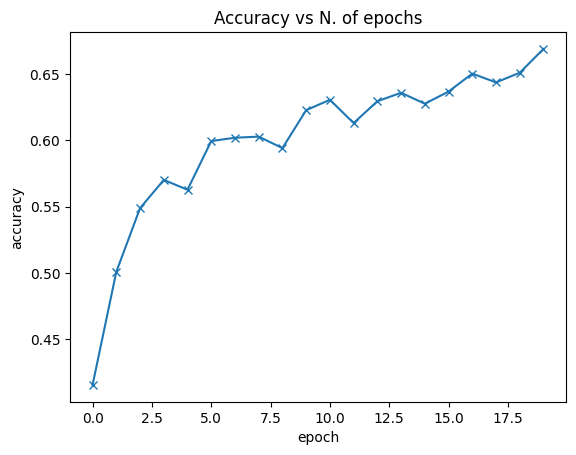

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs N. of epochs')
    plt.show()

plot_accuracies(history)

In [ ]:
plt.show()

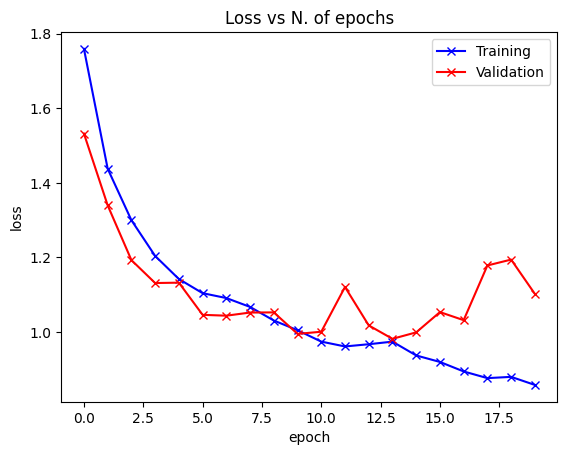

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs N. of epochs');
    plt.show()

plot_losses(history)

In [17]:
evaluate(model, loader_test)

{'val_loss': 1.2660977840423584, 'val_acc': 0.637607753276825}

In [27]:
def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

img, label = test_data[100] 
predict_image(img,model)
label

3

In [ ]:
plt.imshow(img.squeeze(), cmap='gray')
plt.show()

### Save Trained Model State Dict/Entire Model

In [15]:

#torch.save(model.state_dict(), './final_model.pt')

In [ ]:
#torch.save(model, './full_final_model.pt')